In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from skimage import filters

%load_ext autoreload
%autoreload 2
sys.path.append('../src/')
import proj

# Old Method Involving Gaussian PSF Estimation
Finding Gaussian kernel: https://dsp.stackexchange.com/questions/35768/estimating-the-standard-deviation-of-gaussian-filter-from-smoothed-image  

In [ ]:
%reload_ext autoreload
import proj
filt = proj.Filters('../data/stage1/')
# ret = filt.evaluate()
# filt.evaluate('gaussian_blur')

a = 1.0

# fit a gaussian to the first row of the gaussians
def fourier_gaussian(x, sigma, mean=0.0):
    return a * np.exp(-2*(np.pi*(x-mean)*sigma)**2)


def gaussian1d(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2 / (2*sigma**2))


def gaussian2d(h: int, w: int, sigma: float, a: float = 1.0) -> np.ndarray:
    """Create a 2D Gaussian filter.
    """
    x = np.linspace(-w/2, w/2, w)
    y = np.linspace(-h/2, h/2, h)
    X, Y = np.meshgrid(x, y)
    ret = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return a * ret / np.sum(ret)

gaussian_avg = []
for i in range(len(filt.imgs_truth)):
    img_blur = filt.imgs['gaussian_blur'][i]
    img_truth = filt.imgs_truth[i]

    img_blur_fft = np.fft.fft2(img_blur)
    img_truth_fft = np.fft.fft2(img_truth)

    tol = 1e-2
    img_truth_fft = np.where(np.abs(img_truth_fft) < tol, tol, img_truth_fft)
    div = np.abs(img_blur_fft / img_truth_fft)
    gaussians = np.fft.fftshift(np.abs(div[0,:]))

    for j in range(3):
        gaussian_avg.append(gaussians[:,j])

gaussian_avg = np.array(gaussian_avg)
gaussian_avg = np.median(gaussian_avg, axis=0)
N = gaussian_avg.shape[0]

# Smooth signal
gaussian_avg = savgol_filter(gaussian_avg, 20, 1)

# # Set left and right ends of signal to 0
# maxval = np.max(gaussian_avg)
# for i in range(N//2-1):
#     if gaussian_avg[i] < maxval/35:
#         gaussian_avg[N//2+i:] = 0
#         gaussian_avg[:N//2-i] = 0
#         break

sigma = 0.7
x = np.linspace(-np.pi, np.pi, N)
plt.plot(x, gaussian_avg)
y = fourier_gaussian(x, sigma)
plt.plot(x, y)

h, w, = img_blur.shape[:2]
psf = gaussian2d(h, w, sigma)
print("psf min/max: ", psf.max(), psf.min())

n = gaussian_avg.shape[0]
x = np.linspace(-n/2, n/2, n)
popt, pcov = curve_fit(fourier_gaussian, x, gaussian_avg)
sigma = abs(popt[0])
print(a, sigma, 1/sigma)

# New Method

In [ ]:
def calc_sigma(img_truth: np.ndarray, img_blur: np.ndarray, start: float = 0, end: float = 5) -> float:
    """Runs binary search to find the  standard deviation of the Gaussian
    """
    img_blur = cv2.cvtColor(img_blur, cv2.COLOR_RGB2YUV)[:,:,0]/255
    img_truth = cv2.cvtColor(img_truth, cv2.COLOR_RGB2YUV)[:,:,0]/255
    h, w = img_blur.shape[:2]
    error_min = 1e9
    sigma = (start + end) / 2
    while start < end:
        img_blur2 = filters.gaussian(img_truth, sigma=sigma)
        err = np.mean(np.abs(img_blur2 - img_blur))
        if err < error_min:
            error_min = err
            start = sigma
        else:
            end = sigma
        sigma = (start + end) / 2
    return sigma

img_blur = filt.imgs['gaussian_blur'][0]
img_truth = filt.imgs_truth[0]
sigma = calc_sigma(img_truth, img_blur)
print(sigma) # prints 3.75

# img_blur2 = filters.gaussian(img_truth[:,:,channel]/255, sigma=sigma)
# print(np.mean(np.abs(img_blur2 - img_blur[:,:,channel]/255)))
# sigma = 3.5 # I manually played around with some values and 3.5 is better

[(22.0155705073092, 0.6693645837604585, 'gaussian_blur')]
gaussian_blur: FAIL
	Goal: PSNR=26.50, SSIM=0.65
	Actual: PSNR=22.02, SSIM=0.67



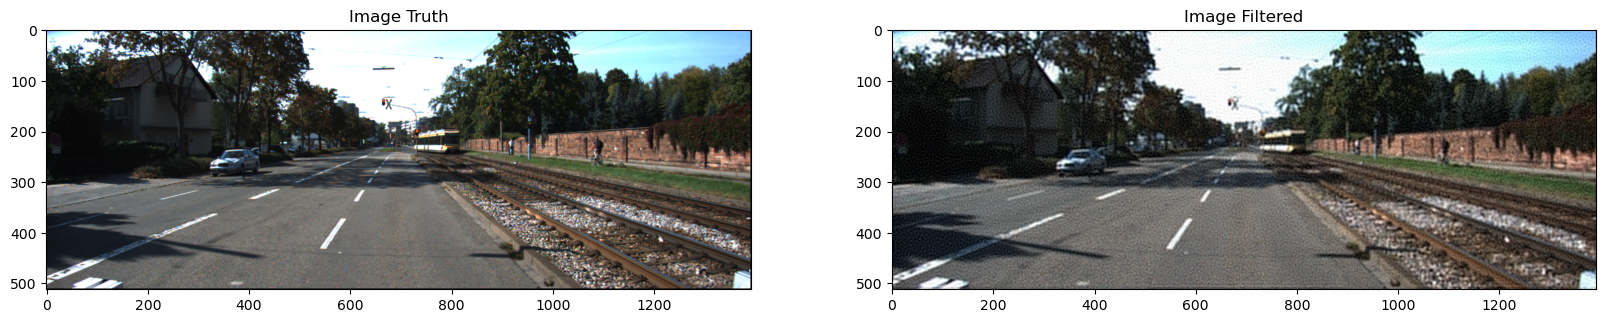

In [165]:
%reload_ext autoreload
import proj
eval = proj.FilterEvaluator('../data/stage1/')
# eval.run()
# eval.run('sp_noise')
eval.run('gaussian_blur')
eval.plot('gaussian_blur')
plt.show()

In [372]:
# Function setup
from skimage import filters, restoration
from skimage.util import img_as_float, img_as_ubyte
eval = proj.FilterEvaluator('../data/stage1/')
img_truth = eval.imgs_truth[0]
img = eval.imgs['gaussian_blur'][0]
def _gaussian2d(h: int, w: int, sigma: float, a: float = 1.0) -> np.ndarray:
    """Create a 2D Gaussian filter.
    """
    x = np.linspace(-w/2, w/2, w)
    y = np.linspace(-h/2, h/2, h)
    X, Y = np.meshgrid(x, y)
    ret = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return a * ret / np.sum(ret)
sigma = 3.5


# Run filtering
# TODO: try with a smaller gaussian kernel
output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
pd = 30
output_img = cv2.copyMakeBorder(output_img, pd, pd, pd, pd, cv2.BORDER_REFLECT)
sigma = 3.6
h, w = 63, 63
psf = _gaussian2d(h, w, sigma=sigma)
output_img = 2*(output_img/255) - 1

output_img[:,:,0] = restoration.unsupervised_wiener(output_img[:,:,0], psf, clip=True)[0]

output_img = np.uint8(255/2*(output_img + 1))
output_img = output_img[pd:-pd, pd:-pd]
output_img = cv2.cvtColor(output_img, cv2.COLOR_YUV2RGB)

output_img = cv2.bilateralFilter(output_img, 7, 75, 150) # 75, 150 best
# sharpen image with 1, 9, 1 kernel
# kernel = np.array([[-1, -1, -1], [-1, 1.8, 1], [-1, -1, -1]])
kernel = -np.ones((3,3))*9/5
kernel[1,1] = 5
output_img = cv2.filter2D(output_img, -1, kernel)

psnr = proj.calc_psnr(img_truth, output_img)
ssim = proj.calc_ssim(img_truth, output_img)
print(f'Benchmark: PSNR: 26.6, SSIM: 0.65')
print(f'Filtered:  PSNR: {psnr:.2f}, SSIM: {ssim:.2f}')


# Plot
plt.figure(figsize=(20,10))
plt.imshow(output_img)

Benchmark: PSNR: 26.6, SSIM: 0.65
Filtered:  PSNR: 21.24, SSIM: 0.69


In [274]:
def filt_func(r, c, sigma=3.5, a=1.0):
    print(2*sigma**2)
    ret = np.exp(-(r**2 + c**2) / (2 * sigma**2))
    print(np.sum(ret))
    return a * ret / np.sum(ret)
filter = filters.LPIFilter2D(filt_func)
# filters.wiener(output_img[:,:,0], predefined_filter=filter)
filters.wiener(img[:,:,0], predefined_filter=filter, K=0.0876)
# filters.wiener(img[:,:,0], impulse_response=filt_func, K=0.00767)

24.5
76.96902001294994


/home/hershey890/miniconda3/envs/tf/lib/python3.10/site-packages/skimage/filters/lpi_filter.py:247: RuntimeWarning: divide by zero encountered in divide
  F = 1 / F * H_mag_sqr / (H_mag_sqr + K)
/home/hershey890/miniconda3/envs/tf/lib/python3.10/site-packages/skimage/filters/lpi_filter.py:247: RuntimeWarning: invalid value encountered in divide
  F = 1 / F * H_mag_sqr / (H_mag_sqr + K)
/home/hershey890/miniconda3/envs/tf/lib/python3.10/site-packages/skimage/filters/lpi_filter.py:247: RuntimeWarning: invalid value encountered in multiply
  F = 1 / F * H_mag_sqr / (H_mag_sqr + K)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])